In [1]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [5]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
array_8m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
awac_6m_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-6m_202110.nc'

print(len(mission_list))

67


In [63]:
wave_heights_each_mission = []
wave_heights = []
wave_x_loc = []
wave_y_loc = []
wave_bathy_each_mission = []
individual_gammas = []
cross_shore_vel_tot = []
celerity_ratio = []

# Cross Shore Location for start of Breaking
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    vel_ew = mission_dataset['velocity_ew'][:]
    vel_ns = mission_dataset['velocity_ns'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    # Transform velocity to cross and along shore components
    # Compute magnitude and direction of velocity
    vel_mag = np.sqrt(vel_ns**2 + vel_ew**2)
    vel_direction = (np.arctan2(vel_ns, vel_ew) * (180/np.pi)) - 90 # subtract 90 to be north 0 convention
    vel_direction_mean = np.nanmean(vel_direction)

    # Project velocity onto the cross shore and along shore directions
    cross_shore_dir = 71.8 * (np.pi/180)
    cross_shore_vel = vel_mag * np.cos(vel_direction + cross_shore_dir)

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)

    # Compute approximate cross shore location of surf zone 
    mission_hs = mission_tools.closest_awac_sig_wave_height(np.median(time), array_8m_file)

    # Compute depth that waves should be breaking in 
    mission_break_depth = mission_hs / gamma

    wave_heights_each_mission.append(wave_heights)
    wave_x_loc.append(wave_x_locs)
    wave_y_loc.append(wave_y_locs)
    wave_bathy_each_mission.append(wave_bathy)
    individual_gammas.append(-1 * np.array(wave_heights)/np.array(wave_bathy))
    cross_shore_vel_tot.append(cross_shore_vel)
    # celerity_ratio.append(np.array(cross_shore_vel)/ np.sqrt(9.8 * -1 * np.array()))

# Flatten the lists and turn into arrays
wave_heights_each_mission = np.concatenate(wave_heights_each_mission).flatten()
wave_x_loc = np.concatenate(wave_x_loc).flatten()
wave_y_loc = np.concatenate(wave_y_loc).flatten()
individual_gammas = np.concatenate(individual_gammas).flatten()
cross_shore_vel_tot = np.concatenate(cross_shore_vel_tot).flatten()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 7321 and the array at index 1 has size 14401

In [49]:
print(wave_heights_each_mission.shape)
print(wave_x_loc.shape)
print(individual_gammas.shape)
print(cross_shore_vel_tot.shape)

(116529,)
(116529,)
(116529,)


In [41]:
# Remove NaN and very large values from the wave heights
individual_gammas_trim = individual_gammas[individual_gammas < 10]

wave_x_loc_nonan = wave_x_loc[~np.isnan(individual_gammas_trim)]
wave_x_loc_nonan = wave_x_loc_nonan[~np.isnan(wave_x_loc_nonan)]

individual_gammas_nonan = individual_gammas_trim[~np.isnan(individual_gammas_trim)]
individual_gammas_nonan = individual_gammas_nonan[~np.isnan(wave_x_loc_nonan)]

print(np.isnan(individual_gammas_nonan))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 116529 but corresponding boolean dimension is 116306

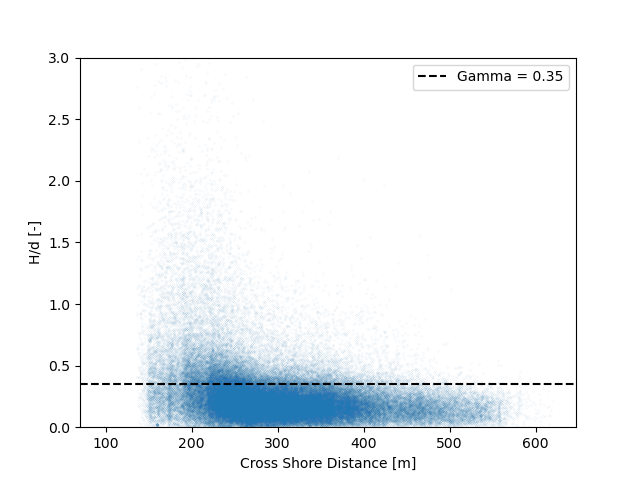

In [60]:
fig, ax = plt.subplots()
ax.scatter(wave_x_loc, individual_gammas, s=0.001)
ax.axhline(0.35, linestyle='dashed', color='k', label='Gamma = 0.35')
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('H/d [-]')
ax.set_ylim(0, 3)
ax.legend()

(0.0, 2.0)

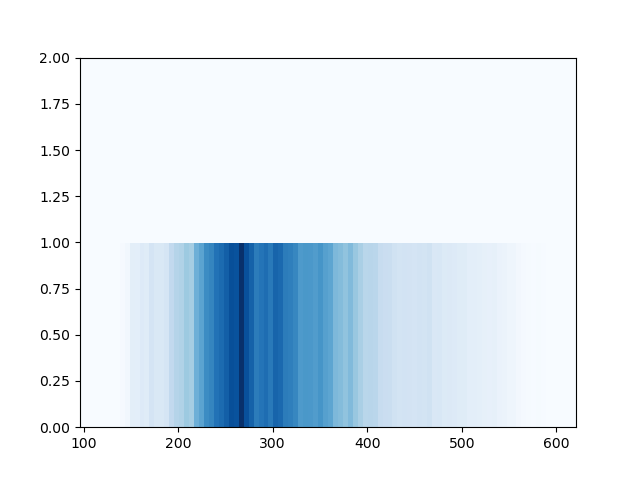

In [34]:
fig, ax = plt.subplots()
ax.hist2d(wave_x_loc_nonan, individual_gammas_nonan, bins=100, cmap='Blues')
ax.set_ylim(0, 2)